<a href="https://colab.research.google.com/github/AlexJurcich/Machine-learning/blob/main/Predicting_Diamond_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Diamond Price**

My goal is to predict the price of diamonds using Regression

Import Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.decomposition import TruncatedSVD

Import Data

In [13]:
df = pd.read_csv('diamonds.csv')

# Drop ID row
df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


For context the x,y,z variables are defined as the following:



*   X: length
*   y: width
*   z: depth





# Exploratory Data Analysis

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


The dataset contain 53,940 total rows with 10 columns. There appears to be no missing data. 3 categorical variables and 7 numeric variables.

In [5]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


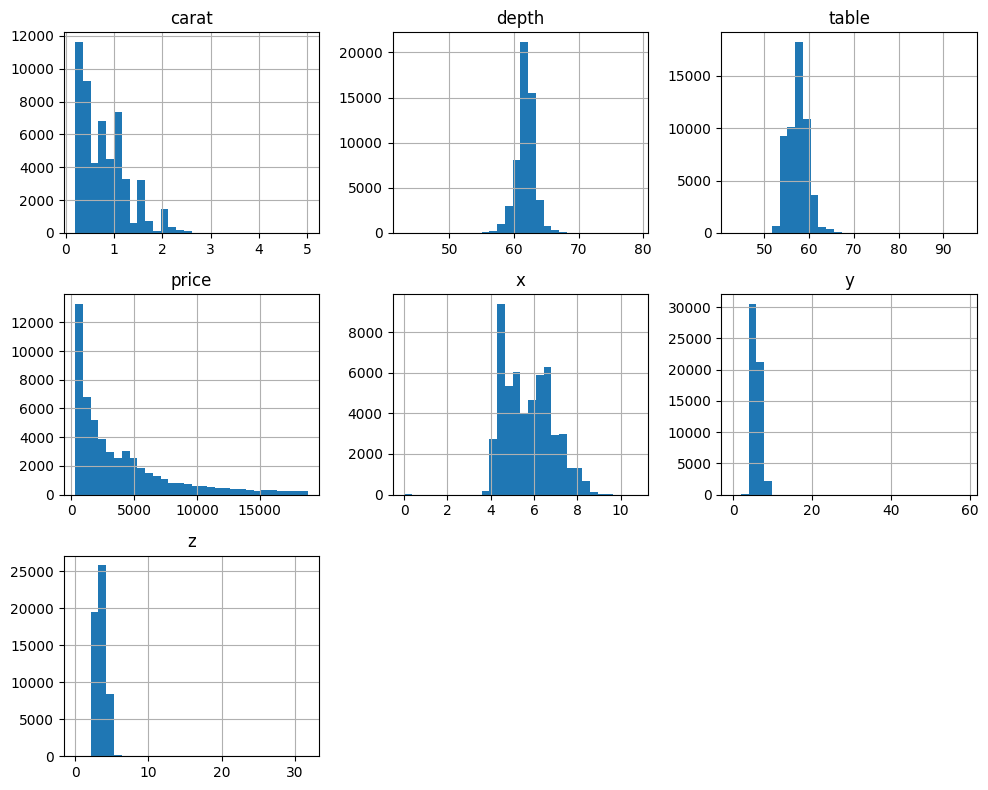

In [20]:
# Distribution plots for numeric data
df.hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()

From the summary statistics we see that the min values for length, width, and height are 0. Which is impossible meaning we need to do some further investigating.

Further more we see that the distributions of price and carat are significantly skewed right. Which may requie log transformaton.

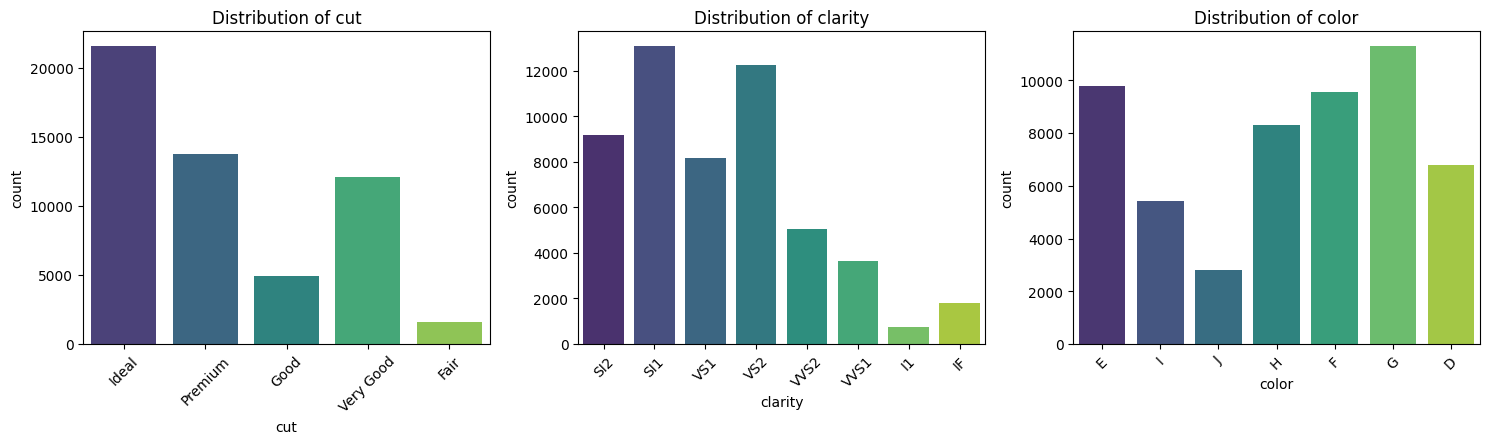

In [21]:
# Distribution of categorical variables
categorical_cols = ['cut', 'clarity', 'color']

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols, 1):
  plt.subplot(3, 3, i)
  sns.countplot(data=df, x=col, hue=col, legend=False, palette="viridis")
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

There appears to be some varaiation in cut and clarity.

# Data Cleaning

In [22]:
missing_X = df[df['x'] == 0].shape[0]
missing_Y = df[df['y'] == 0].shape[0]
missing_Z = df[df['z'] == 0].shape[0]

print(f"Number of rows with missing x values: {missing_X}")
print(f"Number of rows with missing y values: {missing_Y}")
print(f"Number of rows with missing z values: {missing_Z}")

Number of rows with missing x values: 8
Number of rows with missing y values: 7
Number of rows with missing z values: 20


I will remove these instances from the the data set given that the max number is 20 missing.

# Feature Selection

Hot encode categorical variables

In [23]:
df_new = pd.get_dummies(df, drop_first=True)

df_new.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False


Compute correlation matrix

In [24]:
corr_matrix = df_new.corr(numeric_only=True)

target_corr = corr_matrix["price"].sort_values(ascending=False)
print(target_corr)

price            1.000000
carat            0.921591
x                0.884435
y                0.865421
z                0.861249
clarity_SI2      0.128420
table            0.127134
color_I          0.097125
cut_Premium      0.095706
color_J          0.081710
color_H          0.059223
clarity_SI1      0.008957
color_G          0.008556
cut_Very Good    0.006593
cut_Good        -0.000312
clarity_VS2     -0.001062
clarity_VS1     -0.009886
depth           -0.010647
color_F         -0.024161
clarity_IF      -0.049596
clarity_VVS2    -0.052381
clarity_VVS1    -0.095266
cut_Ideal       -0.097175
color_E         -0.101089
Name: price, dtype: float64


Given the correlations above we can narrow our selection down to:



*   carat
*   length
*   width
*   height

Transform Price and carat

In [26]:
df_final = df_new.copy()

df_final['price'] = np.log(df_final['price'])
df_final['carat'] = np.log(df_final['carat'])

df_final.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.469676,61.5,55.0,5.786897,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,-1.560648,59.8,61.0,5.786897,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,-1.469676,56.9,65.0,5.789960,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,-1.237874,62.4,58.0,5.811141,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,-1.171183,63.3,58.0,5.814131,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False


Comapre Before/After distribution plots

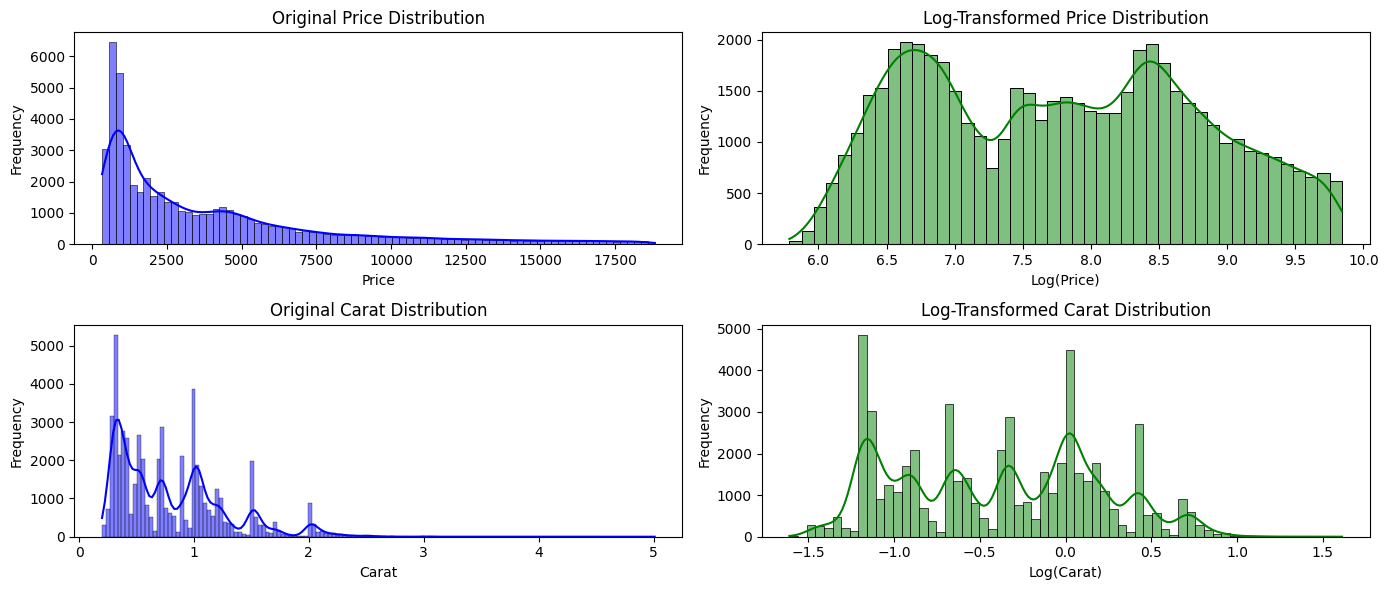

In [28]:
plt.figure(figsize=(14, 6))

# Before transformation - Price
plt.subplot(2, 2, 1)
sns.histplot(df_new['price'], kde=True, color='blue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# After transformation - Log Price
plt.subplot(2, 2, 2)
#correct column name to price
sns.histplot(df_final['price'], kde=True, color='green')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# Before transformation - Carat
plt.subplot(2, 2, 3)
sns.histplot(df_new['carat'], kde=True, color='blue')
plt.title('Original Carat Distribution')
plt.xlabel('Carat')
plt.ylabel('Frequency')

# After transformation - Log Carat
plt.subplot(2, 2, 4)
# correct column name to carat
sns.histplot(df_final['carat'], kde=True, color='green')
plt.title('Log-Transformed Carat Distribution')
plt.xlabel('Log(Carat)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Split the data

In [30]:
X = df_final.drop('price', axis=1)
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Model

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R² Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R² Score: 0.9823032197567001
Mean Squared Error (MSE): 0.018252949011476474
Root Mean Squared Error (RMSE): 0.13510347520133031


Test on some instances

In [39]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]

some_predictions = lin_reg.predict(some_data)

print("Predictions:", some_predictions)
print("Actual Labels:", list(some_labels))

Predictions: [9.60642305 8.36849909 8.66164415 9.07463912 9.41718883]
Actual Labels: [9.69467827290507, 8.420682291035394, 8.653296274408579, 8.748304912379623, 9.470240063415512]


Lasso Regression Model using Grid Search

In [41]:
# Define the parameter grid for alpha
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

# Lasso model
lasso = Lasso(max_iter=10000)

# Grid Search
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

# Best parameters
print(f"Best Alpha: {best_alpha}")

# Make predictions using the best model
y_pred = best_lasso.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Evaluation metrics
print(f"R² Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Alpha: 0.01
R² Score: 0.9559304902983492
Mean Squared Error (MSE): 0.045454512204249786
Root Mean Squared Error (RMSE): 0.21320063837674078


Ridge Regression

In [42]:
# Ridge model
ridge = Ridge()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_alpha = grid_search.best_params_['alpha']
best_ridge = grid_search.best_estimator_

# Best parameters
print(f"Best Alpha: {best_alpha}")

# Make predictions using the best model
y_pred = best_ridge.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Evaluation metrics
print(f"R² Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Alpha: 0.01
R² Score: 0.9823033528441384
Mean Squared Error (MSE): 0.01825281174140866
Root Mean Squared Error (RMSE): 0.13510296718210396


SVD

In [46]:
# Define components and model
n_components = 10
svd = TruncatedSVD(n_components=n_components)

# Standardize data
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# Define model
linear_reg = LinearRegression()
linear_reg.fit(X_train_svd, y_train)

# Make Prediction
y_pred = linear_reg.predict(X_test_svd)

# Parameters
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Number of Components (SVD): {n_components}")
print(f"R² Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Number of Components (SVD): 10
R² Score: 0.9266941190773564
Mean Squared Error (MSE): 0.07560971478012082
Root Mean Squared Error (RMSE): 0.27497220728670163


Summary:

After computing the different models we see that the Ridge Regression Model gave us teh besr r^2 score and RMSE of **0.982** and **0.135** respectively.


# Model Evaluation on Test Set

In [47]:
# Use Ridge model
ridge = Ridge(alpha=0.01)

# Fit the model on the training data
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model on the test set
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"Best Alpha: {best_alpha}")
print(f"R² Score (Test Set): {r2}")
print(f"Mean Squared Error (MSE) (Test Set): {mse}")
print(f"Root Mean Squared Error (RMSE) (Test Set): {rmse}")

Best Alpha: 0.01
R² Score (Test Set): 0.9823033528441384
Mean Squared Error (MSE) (Test Set): 0.01825281174140866
Root Mean Squared Error (RMSE) (Test Set): 0.13510296718210396


Plot

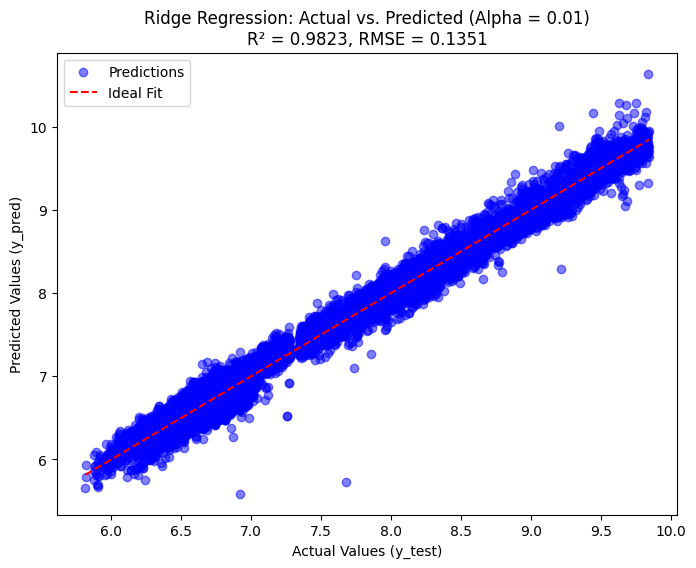

In [48]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')

# Plot the ideal line (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title(f'Ridge Regression: Actual vs. Predicted (Alpha = {best_alpha})\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
plt.legend()

# Show the plot
plt.show()

# Summary

Our final model, using Ridge Regression with an alpha of 0.01, achieved an R² score of 0.9823 and an RMSE of 0.1351 on the test set, indicating strong predictive performance. However, this dataset isn't very complex and doesn't contain all the characteristics that go into determining the price of a diamond, such as cut quality, fluorescence, or specific market trends. As a result, while the model performs well on the given data, its real-world applicability may be limited. To improve its accuracy and generalizability, future work should incorporate more comprehensive features and data sources that better capture the nuances of diamond pricing.